In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('../data/train.csv')

Import relevant libraries and read data

In [14]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

Convert dataset in to numpy array. Then shuffle the data to ensure randomness for training

In [15]:
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255. # feature normalization
_,m_train = X_train.shape

Here, the dataset is split into a development (dev) set and a training set. The data is also transposed to fit the neural network's expected input shape. Finally, pixel values are normalized by dividing by 255, making them range between 0 and 1. This normalization is essential for training stability and faster convergence.

In [16]:
Y_train

array([3, 9, 5, ..., 1, 2, 0], dtype=int64)

In [17]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

This function initializes the weights (W1, W2) and biases (b1, b2) of our neural network. Initialization is important as it affects the starting point of our optimization.

In [18]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

These are activation functions:

    - ReLU (Rectified Linear Unit) is a commonly used activation function for hidden layers. It's computationally efficient and helps tackle vanishing gradient problems.

    - softmax is used in the output layer for multi-class classification problems. It converts raw score outputs into probabilities for each class.

In [19]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

This function computes the forward pass of the network. Given an input X, it calculates intermediate values (Z1, A1, Z2) and the final output A2. This is where our network makes its predictions based on its current weights and biases.

In [20]:
def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [21]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, m):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

Backward propagation calculates how much each weight and bias contributed to the error. The returned values (dW1, db1, dW2, db2) represent gradients, showing the direction and magnitude of changes needed to reduce the error.

In [22]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

This function updates the network's weights and biases in the direction of the negative gradient. This iterative process helps the network learn from its mistakes. alpha is the learning rate, which determines the step size of each update.

In [23]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [24]:
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, m_train)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

This function is the training loop. It combines forward propagation, backward propagation, and the update step for a specified number of iterations. As the network trains, it prints out its accuracy on the training data every 10 iterations.

In [25]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[8 8 1 ... 1 8 1] [3 9 5 ... 1 2 0]
0.1151219512195122


Iteration:  10
[4 3 4 ... 1 3 0] [3 9 5 ... 1 2 0]
0.23358536585365855
Iteration:  20
[4 3 4 ... 1 3 0] [3 9 5 ... 1 2 0]
0.350780487804878
Iteration:  30
[4 3 4 ... 1 3 0] [3 9 5 ... 1 2 0]
0.4258292682926829
Iteration:  40
[4 8 3 ... 1 3 0] [3 9 5 ... 1 2 0]
0.47412195121951217
Iteration:  50
[5 4 3 ... 1 8 0] [3 9 5 ... 1 2 0]
0.5204390243902439
Iteration:  60
[5 9 3 ... 1 8 0] [3 9 5 ... 1 2 0]
0.5617560975609757
Iteration:  70
[5 9 8 ... 1 8 0] [3 9 5 ... 1 2 0]
0.5958048780487805
Iteration:  80
[5 9 8 ... 1 8 0] [3 9 5 ... 1 2 0]
0.6205365853658537
Iteration:  90
[5 9 8 ... 1 8 0] [3 9 5 ... 1 2 0]
0.643
Iteration:  100
[5 9 8 ... 1 8 0] [3 9 5 ... 1 2 0]
0.6604390243902439
Iteration:  110
[5 9 8 ... 1 8 0] [3 9 5 ... 1 2 0]
0.6760243902439025
Iteration:  120
[5 9 8 ... 1 2 0] [3 9 5 ... 1 2 0]
0.6900487804878048
Iteration:  130
[5 9 8 ... 1 2 0] [3 9 5 ... 1 2 0]
0.7022926829268292
Iteration:  140
[5 9 8 ... 1 2 0] [3 9 5 ... 1 2 0]
0.7138292682926829
Iteration:  150
[5 9 8 ... 

In [26]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [5]
Label:  3


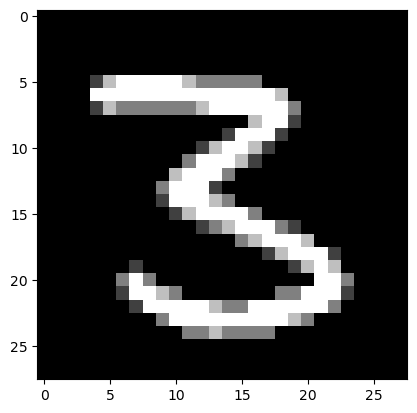

Prediction:  [9]
Label:  9


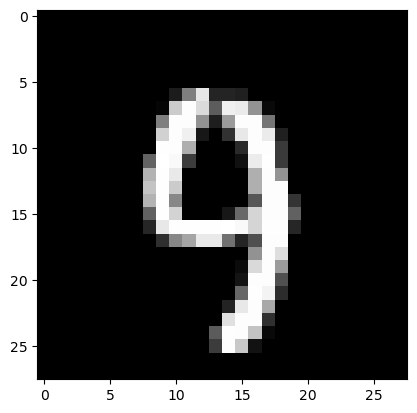

Prediction:  [5]
Label:  5


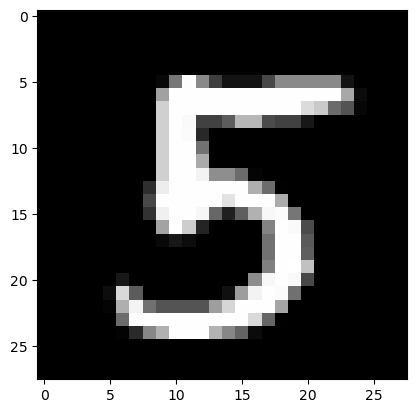

Prediction:  [9]
Label:  9


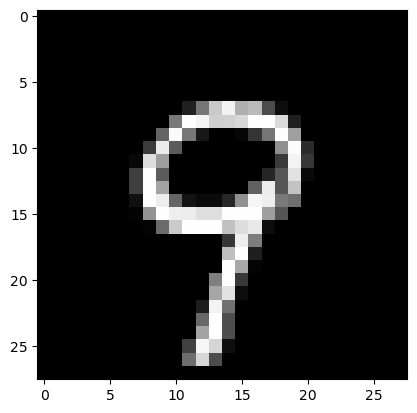

In [27]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [28]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[2 6 1 8 2 2 1 4 8 6 2 3 4 0 5 8 8 8 6 7 0 7 7 1 5 8 6 4 7 5 9 6 4 6 6 7 5
 1 8 3 3 2 7 0 9 7 4 8 4 5 4 8 2 9 4 5 8 0 9 6 0 7 9 1 1 4 4 4 8 8 6 9 3 8
 0 7 0 5 4 7 1 9 9 9 3 7 8 5 5 1 3 4 8 3 2 7 2 6 0 9 0 1 4 8 8 8 4 7 0 8 2
 8 4 4 0 2 1 6 1 6 0 8 7 8 4 3 8 3 9 1 7 5 3 9 8 4 1 7 2 3 7 0 3 3 5 2 7 2
 5 9 2 1 1 6 1 5 0 3 4 2 4 9 6 9 5 4 2 0 4 7 1 8 5 7 3 4 1 2 1 8 0 0 2 5 7
 2 7 1 6 4 3 4 7 9 1 4 0 4 6 4 9 2 4 0 8 1 6 4 5 2 7 1 3 2 4 0 9 7 1 4 3 3
 8 1 5 7 2 8 9 7 5 4 0 0 7 9 4 8 7 6 2 2 0 3 4 4 8 2 3 6 0 2 1 9 7 3 8 5 7
 4 1 1 2 7 9 4 1 1 0 5 6 7 2 2 7 5 4 5 0 2 7 0 1 2 1 1 1 1 1 6 1 7 5 3 4 9
 1 8 9 1 8 9 4 7 4 5 1 8 4 6 1 3 0 9 7 1 5 2 4 0 9 6 7 6 6 3 3 2 3 6 5 6 3
 9 2 1 3 9 6 9 2 7 6 6 3 3 3 6 6 3 4 3 4 4 6 1 2 3 5 4 0 6 2 4 3 8 6 2 9 2
 9 2 2 4 6 7 4 2 2 2 4 7 5 2 9 5 0 1 6 1 8 9 4 2 5 7 5 7 4 7 8 6 5 9 4 4 6
 9 6 8 5 6 3 8 8 5 8 3 5 4 9 0 0 3 2 6 5 1 0 6 7 9 6 1 7 1 1 5 5 3 6 5 0 4
 4 4 6 1 8 2 2 6 7 4 1 3 5 9 1 8 6 8 0 4 1 6 9 1 6 3 4 8 6 1 3 2 2 0 0 4 9
 4 0 7 5 9 6 6 4 9 8 1 2 

0.836

In [29]:
def display_wrong_predictions(X, Y, predictions, W1, b1, W2, b2, num_samples=5):
    wrong_indices = np.where(predictions != Y)[0]  # Find where predictions don't match the actual labels
    displayed = 0
    
    for index in wrong_indices:
        if displayed >= num_samples:  # Limit the number of displayed images to num_samples
            break

        current_image = X[:, index, None]
        predicted_label = predictions[index]
        actual_label = Y[index]

        print("Predicted Label:", predicted_label)
        print("Actual Label:", actual_label)

        current_image = current_image.reshape((28, 28)) * 255
        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.show()

        displayed += 1

Predicted Label: 2
Actual Label: 6


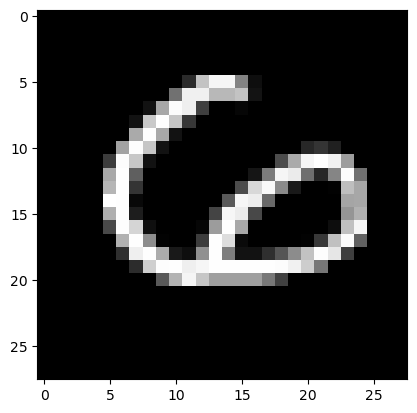

Predicted Label: 5
Actual Label: 3


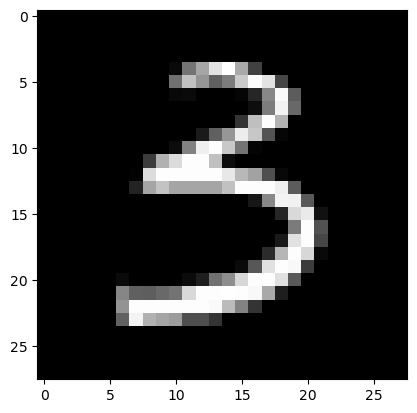

Predicted Label: 8
Actual Label: 5


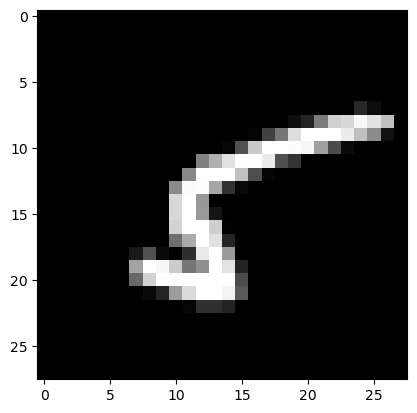

Predicted Label: 8
Actual Label: 3


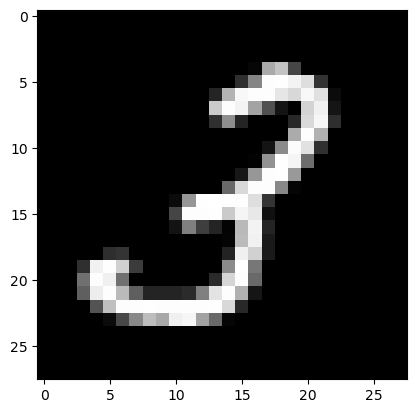

Predicted Label: 8
Actual Label: 3


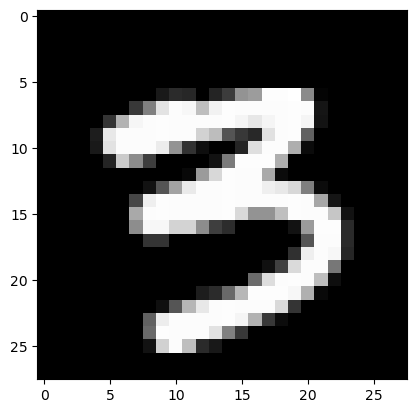

In [30]:
display_wrong_predictions(X_dev, Y_dev, dev_predictions, W1, b1, W2, b2)